# Winging It: A Comparative Machine Learning Approach to Bird Sound Classification

- Tommaso Ghisini: togh22ab@student.cbs.dk
- Alexander James Mealor: alme22ab@stduent.cbs.dk
- Alexander Ries: alri22ac@student.cbs.dk
- Aleksander August Fowler Torp: alto22ad@student.cbs.dk

The monitoring of bird species has the potential for meaningful application far beyond avian conservation efforts, including - but not limited to - environmental change and land usage. Historically onerous tracking efforts have become far less burdensome with the growth of crowd-sourced bird audio recordings and the ability to use this data for species classification. In this paper we address the problem of how such classification efforts can be both automated and optimized by machine learning techniques. Utilizing the BirdCLEF 2023 dataset, we implement three different models - a Random Forest Classifier (RFC), a Convolutional Neural Network (CNN) and a Recurrent Convolutional Neural Network - that build upon audio classification tasks in an evolutionary way.

###Data and Preprocessing Details

- **Data Link**: https://drive.google.com/drive/folders/1OKWG4V5kW3-e44b3XfttJ7LVBqO4eUF_?usp=sharing
(Backup link: https://1drv.ms/f/s!AiqIYDThiBNP4WLLT5VrUad6RpTG?e=1l5ab9)
- **Preprocessing**: The notebook contains functions to preprocess a large amount of data, which may take over 3 hours to run.
- **GPU Training**: The Neural Networks in the notebook were trained on GPUs, so training them on a regular computer may not yield optimal results.

*Please access the provided data link, allocate sufficient processing time, and consider using a GPU-enabled environment for better performance.*

In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import noisereduce as nr

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, ELU, Reshape, LSTM, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


## Exploratory Data Analysis

We start with examining the metatada of the audio samples.

In [ ]:
path_metadata = './data/metadata.csv'
metadata = pd.read_csv(path_metadata)

In [ ]:
metadata.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16941 entries, 0 to 16940
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     16941 non-null  object 
 1   secondary_labels  16941 non-null  object 
 2   type              16941 non-null  object 
 3   latitude          16714 non-null  float64
 4   longitude         16714 non-null  float64
 5   scientific_name   16941 non-null  object 
 6   common_name       16941 non-null  object 
 7   author            16941 non-null  object 
 8   license           16941 non-null  object 
 9   rating            16941 non-null  float64
 10  url               16941 non-null  object 
 11  filename          16941 non-null  object 
dtypes: float64(3), object(9)
memory usage: 1.6+ MB


As we can see, we have a total of 16941 audio samples in our training data. The metadata has 12 columns.

In [ ]:
metadata.describe()

,latitude,longitude,rating
count,16714.000000,16714.000000,16941.000000
mean,12.599897,22.035690,3.727732
std,29.208254,28.743382,1.101060
min,-38.116900,-157.819400,0.000000
25%,-6.256000,5.941125,3.000000
50%,2.359500,26.750650,4.000000
75%,42.787100,36.589850,4.500000
max,71.976900,177.684900,5.000000


### Primary labels

In [ ]:
label_counts = metadata['primary_label'].value_counts()
label_counts_sorted = label_counts.sort_values(ascending=False)  # Sort the label counts in descending order
num_labels = len(label_counts)
print("Number of unique labels:", num_labels)

Number of unique labels: 264


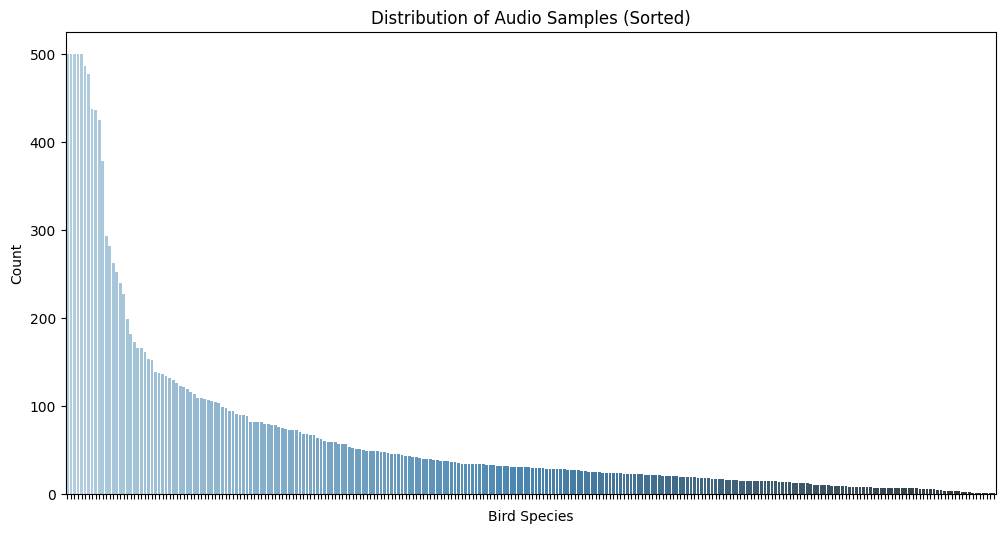

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=metadata, x='primary_label', order=label_counts_sorted.index, palette='Blues_d')

# Remove x-axis labels
ax.set_xticklabels([])

# Reduce number of bins
num_ticks = 10  # Set the desired number of ticks on the x-axis
step = len(label_counts_sorted) // num_ticks


plt.xlabel('Bird Species')
plt.ylabel('Count')
plt.title('Distribution of Audio Samples (Sorted)')
plt.xticks(rotation=90)
plt.show()

The available train data is distributed very unequal. Some bird species have over 500 audio samples whereas some only have 1.

Count Percentiles:
count    264.000000
mean      64.170455
std       98.757285
min        1.000000
25%       14.750000
50%       29.500000
75%       70.500000
max      500.000000
Name: primary_label, dtype: float64


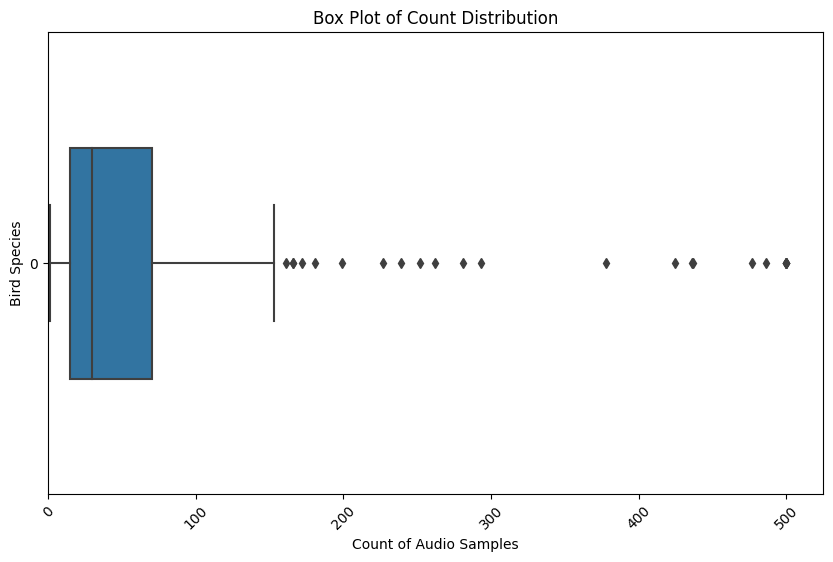

In [ ]:
# Describe and percentiles
percentiles = label_counts.describe(percentiles=[0.25, 0.50, 0.75])
print("Count Percentiles:")
print(percentiles)

# Plot percentiles using seaborn (horizontal box plot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=label_counts, orient='h', width=0.5)
plt.xlabel('Count of Audio Samples')
plt.ylabel('Bird Species')
plt.title('Box Plot of Count Distribution')
plt.xticks(rotation=45)
plt.xlim(left=0)  # Set the left x-axis limit to 0
plt.show()

The 264 bird species have on average around 64 sound samples. 75% of the dataset has 14 or more samples.

Number of bird labels with count below 5: 17


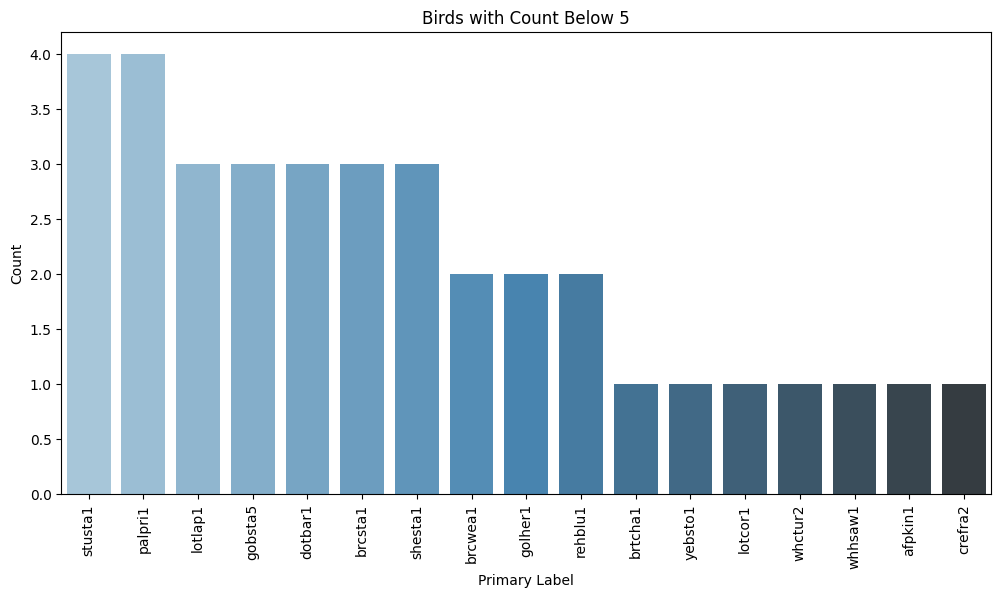

In [ ]:
label_counts = metadata['primary_label'].value_counts()
birds_below_count_5 = label_counts[label_counts < 5].sort_values(ascending=False)

print("Number of bird labels with count below 5:", len(birds_below_count_5))

plt.figure(figsize=(12, 6))
sns.barplot(x=birds_below_count_5.index, y=birds_below_count_5.values, palette='Blues_d')
plt.xlabel('Primary Label')
plt.ylabel('Count')
plt.title('Birds with Count Below 5')
plt.xticks(rotation=90)
plt.show()

Additionally had a look into the species with less than 5 audio samples.

### Secondary labels
 Background species as annotated by the recordist.

In [ ]:
# Count the number of rows with non-empty secondary labels
rows_with_secondary_labels = metadata[metadata['secondary_labels'] != '[]']
num_rows_with_secondary_labels = len(rows_with_secondary_labels)

print("Number of rows with secondary labels:", num_rows_with_secondary_labels)
print("{} % of the audio samples have secondary labels.".format(round((num_rows_with_secondary_labels/len(metadata)*100),2)))

Number of rows with secondary labels: 2305
13.61 % of the audio samples have secondary labels.


In [ ]:
# Filter the DataFrame to include only rows with non-empty secondary labels
rows_with_secondary_labels = metadata[metadata['secondary_labels'] != '[]']

# Extract the secondary labels as lists
secondary_labels_lists = rows_with_secondary_labels['secondary_labels'].apply(eval)

# Get unique lengths of secondary labels where length > 0 and their count
unique_lengths, lengths_counts = secondary_labels_lists.apply(len).value_counts().index, secondary_labels_lists.apply(len).value_counts().values

print("Different number of birds in secondary labels:")
for length, count in zip(unique_lengths, lengths_counts):
    print(f"Additional bird species existent in the audio sample: {length}, Audio Samples: {count}")

Different number of birds in secondary labels:
Additional bird species existent in the audio sample: 1, Audio Samples: 1520
Additional bird species existent in the audio sample: 2, Audio Samples: 564
Additional bird species existent in the audio sample: 3, Audio Samples: 164
Additional bird species existent in the audio sample: 4, Audio Samples: 39
Additional bird species existent in the audio sample: 5, Audio Samples: 11
Additional bird species existent in the audio sample: 6, Audio Samples: 4
Additional bird species existent in the audio sample: 8, Audio Samples: 1
Additional bird species existent in the audio sample: 7, Audio Samples: 1
Additional bird species existent in the audio sample: 9, Audio Samples: 1


The number of background species in the audio samples ranges from 0 to 9.

In [ ]:
# Filter the DataFrame to include only rows with non-empty secondary labels
rows_with_secondary_labels = metadata[metadata['secondary_labels'] != '[]']

# Calculate value counts of secondary labels
label_counts = rows_with_secondary_labels['secondary_labels'].apply(eval).explode().value_counts()

print("Labels in Secondary Labels and their Value Counts:")
print(label_counts)

Labels in Secondary Labels and their Value Counts:
combul2    349
rindov     200
somgre1    152
grbcam1    130
laudov1    100
          ... 
afpkin1      1
loceag1      1
gyhneg1      1
darter3      1
refbar2      1
Name: secondary_labels, Length: 195, dtype: int64


There are 195 different background species in the secondary labels. The number of occurences is widely spread from 1 to 349. However, an empty list in the secondary label column does not mean that there are no background species. Therefore, this has little information value for us.



### Type

In [ ]:
metadata['type'].value_counts()

['song']                                                       4102
['call']                                                       3987
['']                                                           1776
['flight call']                                                1139
['call', 'song']                                                527
                                                               ... 
['aggressive calls', 'call']                                      1
['adult', 'duet', 'song']                                         1
['adult', 'call', 'nocturnal flight call', 'sex uncertain']       1
['dawn song', 'life stage uncertain', 'male', 'song']             1
['demonstrative tapping', 'male']                                 1
Name: type, Length: 796, dtype: int64

In [ ]:
# Count the number of rows with empty type labels secondary labels
rows_with_type_labels = metadata[metadata['type'] != "['']"]
num_rows_with_type_labels = len(rows_with_type_labels)

print("Number of rows with type labels:", num_rows_with_type_labels)
print("{} % of the audio samples have type labels.".format(round((num_rows_with_type_labels/len(metadata)*100),2)))

Number of rows with type labels: 15165
89.52 % of the audio samples have type labels.


In [ ]:
# Filter the DataFrame to include only rows with non-empty secondary labels
rows_with_type_labels = metadata[metadata['type'] != "['']"]

# Extract the secondary labels as lists
secondary_labels_lists = rows_with_type_labels['type'].apply(eval)

# Get unique lengths of secondary labels where length > 0 and their count
unique_lengths, lengths_counts = secondary_labels_lists.apply(len).value_counts().index, secondary_labels_lists.apply(len).value_counts().values

print("Different number of type labels per audio sample:")
for length, count in zip(unique_lengths, lengths_counts):
    print(f"Number of type labels: {length}, Audio Samples: {count}")

Different number of type labels per audio sample:
Number of type labels: 1, Audio Samples: 10097
Number of type labels: 2, Audio Samples: 2656
Number of type labels: 3, Audio Samples: 1810
Number of type labels: 4, Audio Samples: 423
Number of type labels: 5, Audio Samples: 155
Number of type labels: 6, Audio Samples: 14
Number of type labels: 7, Audio Samples: 7
Number of type labels: 8, Audio Samples: 3


In [ ]:
# Filter the DataFrame to include only rows with non-empty secondary labels
rows_with_type_labels = metadata[metadata['type'] != "['']"]

# Calculate value counts of secondary labels
label_counts = rows_with_type_labels['type'].apply(eval).explode().value_counts()

print("Types and their Value Counts:")
print(label_counts)

Types and their Value Counts:
call                     6808
song                     6411
flight call              2235
adult                    1880
male                     1433
                         ... 
long whistles               1
aggressive calls            1
anthropogenic:: rain        1
long call                   1
demonstrative tapping       1
Name: type, Length: 399, dtype: int64


There are 399 different sound types.

In [ ]:
# Filter types with count below 5
types_below_count_5 = label_counts[label_counts < 5]

print("Types with Count Below 5:")
print(types_below_count_5)
print("")

# Filter types with count below 5
types_below_count_2 = label_counts[label_counts < 2]

print("Types with Count Below 2:")
print(types_below_count_2)

Types with Count Below 5:
two-note call            4
Nocturnal flight call    4
courtship call           4
Alarm call               4
aggressive call          4
                        ..
long whistles            1
aggressive calls         1
anthropogenic:: rain     1
long call                1
demonstrative tapping    1
Name: type, Length: 348, dtype: int64

Types with Count Below 2:
intraspecific agressive call    1
mystery sound                   1
bill-snapping                   1
Bill snapping                   1
Lockruf                         1
                               ..
long whistles                   1
aggressive calls                1
anthropogenic:: rain            1
long call                       1
demonstrative tapping           1
Name: type, Length: 266, dtype: int64


We can see that the type data is very heterogenous: For example, the "Bill snapping" is written different or the language is not english ("Lockruf").

Filtering the dataset by the sound type will be difficult due to the high number of distinct types.

### Rating

Float value between 0.0 and 5.0 as an indicator of the quality rating on Xeno-canto and the number of background species, where 5.0 is the highest and 1.0 is the lowest. 0.0 means that this recording has no user rating yet.

In [ ]:
label_counts = metadata['rating'].value_counts()
label_counts_sorted = label_counts.sort_index() # Sort the label counts in descending order
num_labels = len(label_counts)
print("Number of ratings:", num_labels)


Number of ratings: 11


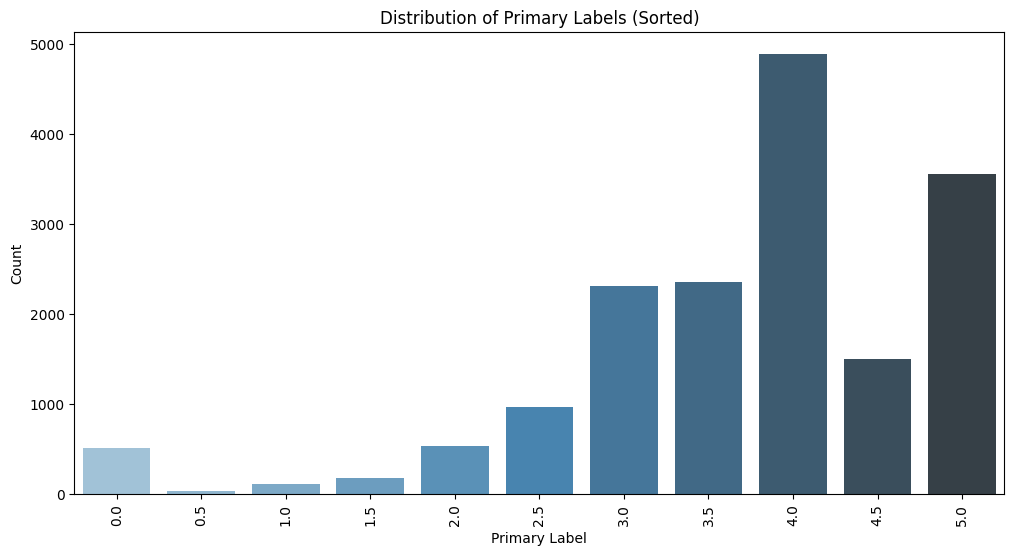

0.0     514
0.5      28
1.0     112
1.5     174
2.0     533
2.5     960
3.0    2314
3.5    2354
4.0    4895
4.5    1495
5.0    3562
Name: rating, dtype: int64


In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=metadata, x='rating', order=label_counts_sorted.index, palette='Blues_d')  # Specify the order of the labels
plt.xlabel('Primary Label')
plt.ylabel('Count')
plt.title('Distribution of Primary Labels (Sorted)')
plt.xticks(rotation=90)
plt.show()
print(label_counts_sorted)

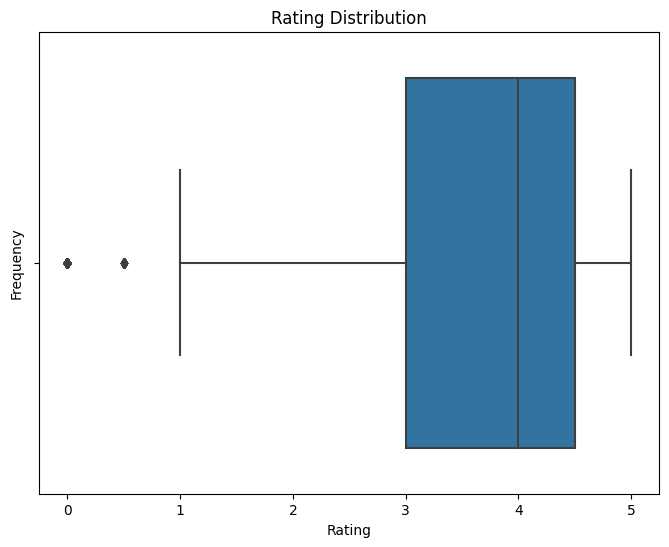

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=metadata, x='rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')
plt.show()

The rating would be a useful filter for data cleaning. However, since the rating 0.0 indicates not low quality but that a rating is not existent, we will lose a lot of information by excluding audio samples of a certain rating. Therefore, we will not use the rating as a filter for data cleaning.

## Data Preprocessing

In [ ]:
class AudioPreprocessor:
    def __init__(self, sample_rate=32000, target_sample_rate=16000, audio_length=654170, top_db=20,
                 noise_reduction=True, trim_silence=True, normalize=True):
        """
            Initialize the AudioPreprocessor object with the specified parameters.

        Args:
            sample_rate (int, optional): The sample rate of the audio. Defaults to 32000.
            target_sample_rate (int, optional): The target sample rate after resampling. Defaults to 16000.
            audio_length (int, optional): The desired length of the audio. Defaults to 654170.
            top_db (int, optional): The threshold in decibels below reference to consider as silence. Defaults to 20.
            noise_reduction (bool, optional): Whether to perform noise reduction. Defaults to True.
            trim_silence (bool, optional): Whether to trim silence from the audio. Defaults to True.
            normalize (bool, optional): Whether to normalize the audio. Defaults to True.
        """                 
        self.sample_rate = sample_rate
        self.target_sample_rate = target_sample_rate
        self.audio_length = audio_length
        self.top_db = top_db
        self.noise_reduction = noise_reduction
        self.trim_silence = trim_silence
        self.normalize = normalize


    def preprocess_audio_mel(self, file_path, n_mels=64, resample=True, snippet_duration=None, audio=None):
        """
        Preprocesses audio by loading, resampling, applying noise reduction, trimming silence,
        normalizing, and converting it to a mel spectrogram in decibel scale.

        Args:
            file_path (str): The path to the audio file.
            n_mels (int, optional): The number of mel bands to generate. Defaults to 64.
            resample (bool, optional): Whether to resample the audio. Defaults to True.
            snippet_duration (float, optional): The duration in seconds of the audio snippet to extract. Defaults to None.
            audio (ndarray, optional): Preloaded audio data. Defaults to None.

        Returns:
            ndarray: Mel spectrogram in decibel scale.
        """         
        if audio is None:
            audio, _ = librosa.load(file_path, sr=self.sample_rate, mono=True)

        if resample:
            audio = librosa.resample(audio, orig_sr=self.sample_rate, target_sr=self.target_sample_rate)
        sample_rate = self.target_sample_rate

        if self.noise_reduction:
            audio = nr.reduce_noise(y=audio, sr=sample_rate, y_noise=audio[:int(sample_rate * 2)], n_jobs=-1)

        if self.trim_silence:
            audio, _ = librosa.effects.trim(audio, top_db=self.top_db)

        if snippet_duration is not None:
            if len(audio) < (snippet_duration * sample_rate):
                audio = librosa.util.pad_center(data=audio, size=(snippet_duration * sample_rate))
            else:
                audio = audio[:(snippet_duration * sample_rate)]
        else:
            audio = np.pad(audio[:self.audio_length], (0, max(0, self.audio_length - len(audio))), 'constant')

        if self.normalize:
            audio = librosa.util.normalize(audio)

        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        return spectrogram_db
    
    def oversample(self, audio, technique):
        """
        Performs audio oversampling using different techniques such as time stretching,
        pitch shifting, adding noise, and time shifting.

        Args:
            audio (ndarray): Audio data
            technique (str): The oversampling technique to apply

        Raises:
            ValueError: Oversample technique not recognized

        Returns:
            ndarray: The oversampled audio data
        """        
        if technique == 'time_stretch':
            rate = np.random.uniform(0.8, 1.2)
            return librosa.effects.time_stretch(audio, rate=rate)
        elif technique == 'pitch_shift':
            n_steps = np.random.randint(-3, 4)
            return librosa.effects.pitch_shift(audio, sr=self.target_sample_rate, n_steps=n_steps)
        elif technique == 'add_noise':
            noise = np.random.randn(len(audio))
            return audio + 0.05 * noise
        elif technique == 'time_shift':
            shift = np.random.randint(-80000, 80000)
            return np.roll(audio, shift)
        else:
            raise ValueError('Oversample technique not recognized')


    def preprocess(self, path_metadata, path_audio_files, n_mels=64,
                   oversample_technique=None, target_samples=None):
        """
        Preprocesses audio files based on the provided metadata and audio file paths.

        Args:
            path_metadata (str): The path to the metadata file (CSV format)
            path_audio_files (str): The path to the directory containing audio files
            n_mels (int, optional): The number of mel bands to generate. Defaults to 64.
            oversample_technique (str, optional): The oversampling technique to apply. Defaults to None.
            target_samples (int, optional): The target number of samples per class. Defaults to None.

        Returns:
            DataFrame: The preprocessed audio features in a DataFrame
        """        
        metadata = pd.read_csv(path_metadata)
        features_list = []

        for species, group_df in tqdm(metadata.groupby('common_name'), desc='Processing'):
            num_samples = len(group_df)

            for _, row in group_df.iterrows():
                file_path = os.path.join(path_audio_files, row['filename'])

                if os.path.isfile(file_path):
                    spectrogram_db = self.preprocess_audio_mel(file_path, n_mels)
                    features_list.append({'common_name': species, 'filename': row['filename'], 'features': spectrogram_db})

            techniques = ['time_stretch', 'pitch_shift', 'add_noise', 'time_shift', 'change_vol']
            if oversample_technique in techniques and num_samples < target_samples:
                num_oversamples = min(target_samples - num_samples, target_samples)
                selected_samples = np.random.choice(group_df['filename'], num_oversamples, replace=True)

                for sample in selected_samples:
                    file_path = os.path.join(path_audio_files, sample)
                    audio, _ = librosa.load(file_path, sr=self.sample_rate, mono=True)
                    transformed_audio = self.oversample(audio, oversample_technique)
                    spectrogram_db = self.preprocess_audio_mel(file_path=None, n_mels=n_mels, audio=transformed_audio)
                    features_list.append({'common_name': species, 'filename': sample, 'features': spectrogram_db})

        df = pd.DataFrame(features_list)
        return df


    def preprocess_snippets(self, path_metadata, path_audio_files, snippet_duration=None):
        """
        Preprocesses audio snippets based on the provided metadata.

        Args:
            audio_path (str): The path to the directory containing the audio files.
            meta_data (pd.DataFrame): DataFrame containing metadata for the audio snippets.
            snippet_duration (float, optional): The duration of each audio snippet in seconds. Defaults to None.

        Returns:
            pd.DataFrame: A DataFrame containing the preprocessed audio snippets and corresponding metadata.
        """         
        new_rows = []
        metadata = pd.read_csv(path_metadata)

        for _, row in metadata.iterrows():
            filename = os.path.join(path_audio_files, row['filename'])

            audio, _ = librosa.load(filename, sr=32000, mono=True)
            audio = librosa.resample(audio, orig_sr=32000, target_sr=16000)

            if snippet_duration is not None:

                samples_per_snippet = int(16000 * snippet_duration)

                num_snippets = len(audio) // samples_per_snippet
                snippets = []
                for i in range(num_snippets):
                    start = i * samples_per_snippet
                    end = start + samples_per_snippet
                    snippet = audio[start:end]
                    snippets.append(snippet)

                snippets = np.array(snippets)
            else:
                snippets = np.array(audio)
                
            snippet_rows = []
            
            for snippet in snippets:       
                snippet_rows.append({
                    'primary_label': row['primary_label'],
                    'secondary_labels': row['secondary_labels'],
                    'type': row['type'],
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    'scientific_name': row['scientific_name'],
                    'common_name': row['common_name'],
                    'author': row['author'],
                    'license': row['license'],
                    'rating': row['rating'],
                    'url': row['url'],
                    'filename': row['filename'],
                    'features': self.preprocess_audio_mel(file_path=None,
                                                          audio=snippet,
                                                          n_mels=64,
                                                          resample=False,
                                                          snippet_duration=snippet_duration),
                    })
            new_rows.extend(snippet_rows)
        
        df = pd.DataFrame(new_rows)
        return df

### Filtering and Train-Test Split

In [ ]:
# filter for classes with more than 10 samples
class_counts = metadata['common_name'].value_counts()
valid_classes = class_counts[class_counts > 10].index
metadata = metadata[metadata['common_name'].isin(valid_classes)]


# split metadata into train and test
meta_train, meta_test = train_test_split(metadata, test_size=0.2, shuffle=True, stratify=metadata['common_name'])

meta_train.to_csv('./data/train/metadata_train.csv')
meta_test.to_csv('./data/test/metadata_test.csv')

### Initiating Preprocessor

In [ ]:
path_audio_files = './data/audio'

ap = AudioPreprocessor(sample_rate=32000, target_sample_rate=16000, audio_length=654170,
                       top_db=20, noise_reduction=True, trim_silence=True, normalize=True)

### Preprocessing

Train and test data is preprocessed. Oversampling technique and target sample can be specified.

In [ ]:
# df_train = ap.preprocess(path_metadata, path_audio_files, n_mels=64,
#                          oversample_technique='add_noise', target_samples=50)

# df_test = ap.preprocess(path_metadata, path_audio_files, n_mels=64,
#                          oversample_technique=None, target_samples=None)

# df_train.to_pickle('data/train/df_train.pkl')
# df_test.to_pickle('data/test/df_test.pkl')


As the preprocessing takes a long time (up to 3 hours) we proceed by loading the preprocessed data

In [ ]:
df_train = pd.read_pickle('./data/train/df_train.pkl')
df_test = pd.read_pickle('./data/test/df_test.pkl')

### Preprocessing with Snippets

Train and test data is preprocessed. Oversampling technique and target sample can be specified.

In [ ]:
# df_snippet_train = ap.preprocess_snippets(path_metadata, path_audio_files, snippet_duration=5)
# df_snippet_test = ap.preprocess_snippets(path_metadata, path_audio_files, snippet_duration=5)

# df_snippet_train.to_pickle('data/train/df_snippet_train.pkl')
# df_snippet_test.to_pickle('data/test/df_snippet_test.pkl')

As the preprocessing takes a long time (up to 5 hours) we proceed by loading the preprocessed data

In [ ]:
df_snippet_train = pd.read_pickle('./data/train/df_snippet_train.pkl')
df_snippet_test = pd.read_pickle('./data/test/df_snippet_test.pkl')

## Modelling - Pipeline 1

In [ ]:
def plot_history(history):
    # Get training and validation loss values
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the training and validation loss
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'tab:blue', label='Training loss')
    plt.plot(epochs, val_loss, 'tab:orange', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Stack the features for train and test sets
X_train = np.stack(df_train['features'].values)
y_train = df_train['common_name'].values

X_test = np.stack(df_test['features'].values)
y_test = df_test['common_name'].values

# Split the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Expand the dimensions of the data to fit the CNN input shape
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train_encoded)
y_val_one_hot = to_categorical(y_val_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

### Baseline Model - Random Forest

In [ ]:
# Reshape data
X_train_2d = X_train.reshape((X_train.shape[0], -1))
X_test_2d = X_test.reshape((X_test.shape[0], -1))

# Encoding labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Creating the RandomForest model
clf = RandomForestClassifier(n_estimators=100, bootstrap=True, verbose=1, n_jobs=-1)

# Train the model using the training sets
clf.fit(X_train_2d, y_train_encoded)

# Predict the response for test dataset
y_pred = clf.predict(X_test_2d)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
# Compute the accuracy score
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy: ", round(accuracy,2))

# Classification matrix
matrix = classification_report(y_test_encoded, y_pred)
lines = matrix.split('\n')[:1]
lines += matrix.split('\n')[-4:]
for line in lines:
  print(line)

Accuracy:  0.22
              precision    recall  f1-score   support
    accuracy                           0.22      1665
   macro avg       0.08      0.06      0.05      1665
weighted avg       0.16      0.22      0.15      1665



### Convolutional Neural Network (CNN)

In [ ]:
n_classes = df_train['common_name'].nunique()
input_shape = X_train[0].shape

model = Sequential([
    # Layer 1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 2
    Conv2D(64, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 3
    Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 4
    Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 5
    Conv2D(512, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 6
    Conv2D(512, (2, 2), padding='valid', activation='relu'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    
    # Layer 7
    Conv2D(1024, (1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    
    # Layer 8
    Conv2D(n_classes, (1, 1), padding='valid'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Dense Layer
    Flatten(),
    Dense(n_classes, activation='softmax')
])
# Summary of the model
model.summary()

# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=1)

# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=30, batch_size=32)

# Evaluate/Predict
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
y_pred_one_hot = model.predict(X_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 1278, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 64, 1278, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 64, 1278, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 639, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 639, 64)       18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 639, 64)      2

In [ ]:
model.save('./data/models/CNN')

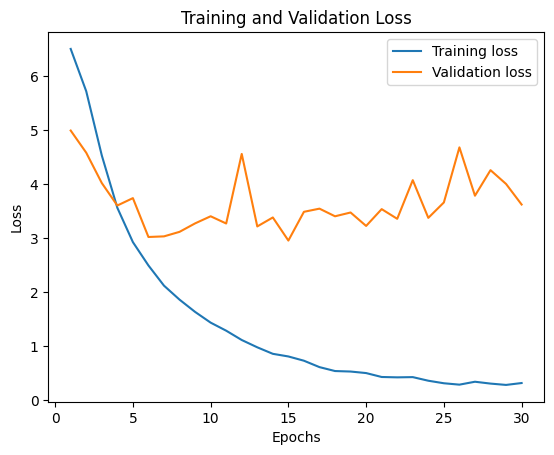

In [ ]:
plot_history(history)

In [ ]:
# Evaluate the model
print('Test Loss: {}'.format(round(test_loss, 2)))
print('Test Accuracy: {}\n'.format(round(test_acc,2)))

# Classification matrix
y_pred = np.argmax(y_pred_one_hot, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

matrix = classification_report(y_true, y_pred)
lines = matrix.split('\n')[:1]
lines += matrix.split('\n')[-4:]
for line in lines:
  print(line)

Test Loss: 3.59
Test Accuracy: 0.48

              precision    recall  f1-score   support
    accuracy                           0.48      1665
   macro avg       0.25      0.24      0.23      1665
weighted avg       0.49      0.48      0.47      1665



### Recurrent Convolutional Neural Network (RCNN)

In [ ]:
n_classes = df_train['common_name'].nunique()
input_shape = X_train[0].shape

model = Sequential([
    # Layer 1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 2
    Conv2D(64, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 3
    Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 4
    Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 5
    Conv2D(512, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 6
    Conv2D(512, (2, 2), padding='valid', activation='relu'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    
    # Layer 7
    Conv2D(1024, (1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    
    Reshape((-1, 512)),  # We have to reshape our data for LSTM
    LSTM(512),

    Dropout(0.3),
    BatchNormalization(),
    Dense(df_train['common_name'].nunique(), activation='softmax')  
])

# Summary of the model
model.summary()

# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=1)

# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=40, batch_size=32)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)

# Classification matrix
y_pred_one_hot = model.predict(X_test)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 1278, 32)      320       
                                                                 
 batch_normalization_8 (Batc  (None, 64, 1278, 32)     128       
 hNormalization)                                                 
                                                                 
 re_lu_7 (ReLU)              (None, 64, 1278, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 639, 32)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 639, 64)       18496     
                                                                 
 batch_normalization_9 (Batc  (None, 32, 639, 64)     

In [ ]:
model.save('./data/models/RCNN')

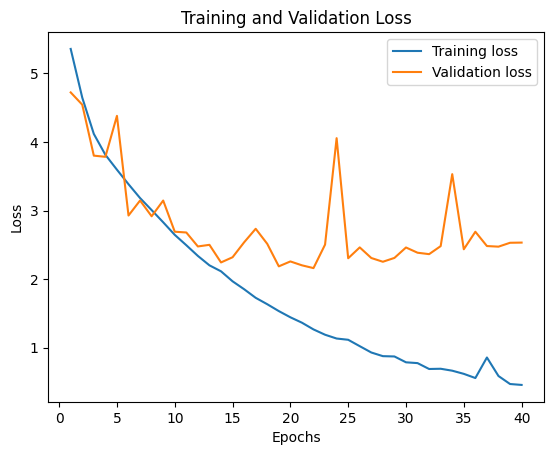

In [ ]:
plot_history(history)

In [ ]:
# Evaluate the model
print('Test Loss: {}'.format(round(test_loss, 2)))
print('Test Accuracy: {}\n'.format(round(test_acc,2)))

# Classification matrix
y_pred = np.argmax(y_pred_one_hot, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

matrix = classification_report(y_true, y_pred)
lines = matrix.split('\n')[:1]
lines += matrix.split('\n')[-4:]
for line in lines:
  print(line)

Test Loss: 2.54
Test Accuracy: 0.59

              precision    recall  f1-score   support
    accuracy                           0.59      1665
   macro avg       0.43      0.41      0.40      1665
weighted avg       0.62      0.59      0.59      1665



## Modeling - Pipeline 2  (5s snippets)

In [ ]:
# Stack the features for train and test sets
X_train = np.stack(df_snippet_train['features'].values)
y_train = df_snippet_train['common_name'].values

X_test = np.stack(df_snippet_test['features'].values)
y_test = df_snippet_test['common_name'].values

# Split the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Expand the dimensions of the data to fit the CNN input shape
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train_encoded)
y_val_one_hot = to_categorical(y_val_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

### Baseline Model - Random Forest

In [ ]:
# Reshape data
X_train_2d = X_train.reshape((X_train.shape[0], -1))
X_test_2d = X_test.reshape((X_test.shape[0], -1))

# Encoding labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Creating the RandomForest model
clf = RandomForestClassifier(n_estimators=100, bootstrap=True, verbose=1, n_jobs=-1)

# Train the model using the training sets
clf.fit(X_train_2d, y_train_encoded)

# Predict the response for test dataset
y_pred = clf.predict(X_test_2d)


In [ ]:
# Classification matrix
matrix = classification_report(y_test_encoded, y_pred)
lines = matrix.split('\n')[:1]
lines += matrix.split('\n')[-4:]
for line in lines:
  print(line)

              precision    recall  f1-score   support
    accuracy                           0.27     13300
   macro avg       0.15      0.06      0.06     13300
weighted avg       0.27      0.27      0.21     13300



### Convolutional Neural Network (CNN)

In [ ]:
n_classes = df_snippet_train['common_name'].nunique()
input_shape = X_train[0].shape

model = Sequential([
    # Layer 1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 2
    Conv2D(64, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 3
    Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 4
    Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 5
    Conv2D(512, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 6
    Conv2D(512, (2, 2), padding='valid', activation='relu'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    
    # Layer 7
    Conv2D(1024, (1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    
    # Layer 8
    Conv2D(n_classes, (1, 1), padding='valid'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Dense Layer
    Flatten(),
    Dense(n_classes, activation='softmax')
])
# Summary of the model
model.summary()

# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=1)

# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=10, batch_size=32)

# Evaluate/Predict
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
y_pred_one_hot = model.predict(X_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 157, 32)      320       
                                                                 
 batch_normalization_16 (Bat  (None, 128, 157, 32)     128       
 chNormalization)                                                
                                                                 
 re_lu_14 (ReLU)             (None, 128, 157, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 78, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 78, 64)        18496     
                                                                 
 batch_normalization_17 (Bat  (None, 64, 78, 64)      

In [ ]:
model.save('./data/models/CNN_5s')

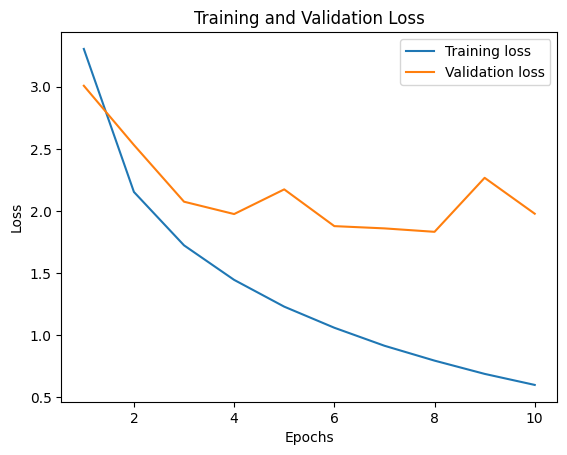

In [ ]:
plot_history(history)

In [ ]:
# Evaluate the model
print('Test Loss: {}'.format(round(test_loss, 2)))
print('Test Accuracy: {}\n'.format(round(test_acc,2)))

# Classification matrix
y_pred = np.argmax(y_pred_one_hot, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

matrix = classification_report(y_true, y_pred)
lines = matrix.split('\n')[:1]
lines += matrix.split('\n')[-4:]
for line in lines:
  print(line)

Test Loss: 2.01
Test Accuracy: 0.62

              precision    recall  f1-score   support
    accuracy                           0.62     13300
   macro avg       0.47      0.38      0.39     13300
weighted avg       0.63      0.62      0.61     13300



### Recurrent Convolutional Neural Network (RCNN)

In [ ]:
n_classes = df_snippet_train['common_name'].nunique()
input_shape = X_train[0].shape

model = Sequential([
    # Layer 1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 2
    Conv2D(64, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 3
    Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 4
    Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 5
    Conv2D(512, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer 6
    Conv2D(512, (2, 2), padding='valid', activation='relu'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    
    # Layer 7
    Conv2D(1024, (1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    
    Reshape((-1, 512)),  # We have to reshape our data for LSTM
    LSTM(512),

    Dropout(0.3),
    BatchNormalization(),
    Dense(df_snippet_train['common_name'].nunique(), activation='softmax')  
])

# Summary of the model
model.summary()

# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=1)

# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=20, batch_size=32)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)

# Classification matrix
y_pred_one_hot = model.predict(X_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 128, 157, 32)      320       
                                                                 
 batch_normalization_24 (Bat  (None, 128, 157, 32)     128       
 chNormalization)                                                
                                                                 
 re_lu_21 (ReLU)             (None, 128, 157, 32)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 78, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 78, 64)        18496     
                                                                 
 batch_normalization_25 (Bat  (None, 64, 78, 64)      

In [ ]:
model.save('./data/models/RCNN_5s')

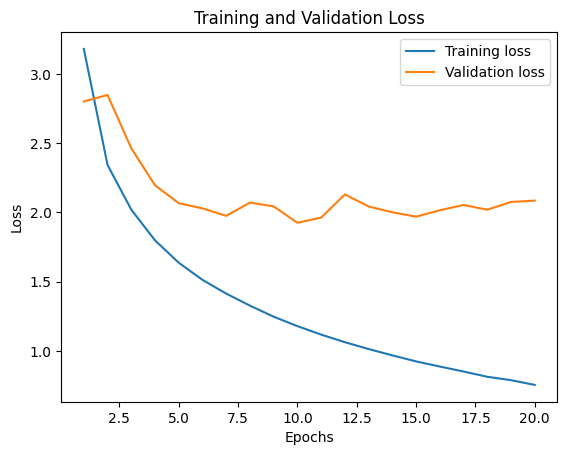

In [ ]:
plot_history(history)

In [ ]:
# Evaluate the model
print('Test Loss: {}'.format(round(test_loss, 2)))
print('Test Accuracy: {}\n'.format(round(test_acc,2)))

# Classification matrix
y_pred = np.argmax(y_pred_one_hot, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

matrix = classification_report(y_true, y_pred)
lines = matrix.split('\n')[:1]
lines += matrix.split('\n')[-4:]
for line in lines:
  print(line)

Test Loss: 2.05
Test Accuracy: 0.63

              precision    recall  f1-score   support
    accuracy                           0.63     13300
   macro avg       0.41      0.38      0.37     13300
weighted avg       0.63      0.63      0.62     13300

